In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from utils.eval import compute_dts
from utils import compute_tempo as ctempo
import utils.extract_dance_onsets as edo
from utils.extract_dance_onsets import detrend_signal_array

In [ ]:
# a = 60 
# b = 140

# metric = "pos"
# mode = "zero_uni"

# main_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"


# save_dir = f"./saved_result/tempo_{a}_{b}/"
# onset_dir = f"./extracted_body_onsets_sept25/{metric}/"
# f_path = "./aist_dataset/aist_annotation/keypoints2d"
# aist_filelist = os.listdir(f_path)


# count= 0
# for idx, filename in enumerate(tqdm(aist_filelist)):
    
#     file_info = filename.split("_")
#     dance_genre = file_info[0] 
#     situation = file_info[1] 
#     camera_id = file_info[2] 
#     dancer_id = file_info[3]
#     music_id = file_info[4]
#     choreo_id = file_info[5].strip(".pkl")
    
#     torso_y = ctempo.load_pickle(os.path.join("/itf-fi-ml/home/sagardu/aist_tempo_COM/aist_tempo_est/extracted_body_onsets/pos/ax1", f"torso_{mode}_{filename}"))                      

#     left_hand_y  = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"left_wrist_{mode}_{filename}"))
#     right_hand_y = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"right_wrist_{mode}_{filename}"))
    
#     left_foot_y  = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"left_ankle_{mode}_{filename}"))
#     right_foot_y = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"right_ankle_{mode}_{filename}"))
    
    
#     bothhand_y = ctempo.filter_dir_onsets_by_threshold((left_hand_y['sensor_onsets'] + right_hand_y['sensor_onsets']), threshold_s= 0.2, fps=60)
#     bothfoot_y = ctempo.filter_dir_onsets_by_threshold((left_foot_y['sensor_onsets'] + right_foot_y['sensor_onsets']), threshold_s= 0.2, fps=60)

#     break

## Prepare and save onset matrices for PCA

In [ ]:
metric = "vel"
mode = "zero_uni"

onset_dir = f"./extracted_body_onsets_sept25/{metric}/"
f_path = "./aist_dataset/aist_annotation/keypoints2d"
aist_filelist = os.listdir(f_path)

onset_matrix_dir = f"/itf-fi-ml/home/sagardu/aist_tempo_est/PCA/onset_matrices/{metric}"
os.makedirs(onset_matrix_dir, exist_ok=True)

json_filename = "music_id_tempo.json"
with open(json_filename, "r") as file:
    aist_tempo = json.load(file)

for idx, filename in enumerate(tqdm(aist_filelist)):
    
    file_info = filename.split("_")
    dance_genre = file_info[0] 
    situation = file_info[1] 
    camera_id = file_info[2] 
    dancer_id = file_info[3]
    music_id = file_info[4]
    choreo_id = file_info[5].strip(".pkl")
    
    
    test_path = os.path.join(onset_dir, "ax0", f"left_wrist_{mode}_{filename}")
    isExist = os.path.exists(test_path) 
    if not isExist:
        continue
    
    # --- Load onset pickles (y-axis only for now) ---
    torso_y = ctempo.load_pickle(os.path.join(
        "/itf-fi-ml/home/sagardu/aist_tempo_COM/aist_tempo_est/extracted_body_onsets/pos/ax1",
        f"torso_{mode}_{filename}"
    ))
    left_hand_y  = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"left_wrist_{mode}_{filename}"))
    right_hand_y = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"right_wrist_{mode}_{filename}"))
    left_foot_y  = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"left_ankle_{mode}_{filename}"))
    right_foot_y = ctempo.load_pickle(os.path.join(onset_dir, "ax1", f"right_ankle_{mode}_{filename}"))
    
    # --- Optional: merge bilateral onsets (filtering small time gaps) ---
    bothhand_y = ctempo.filter_dir_onsets_by_threshold(
        left_hand_y['sensor_onsets'] + right_hand_y['sensor_onsets'], threshold_s=0.2, fps=60
    )
    bothfoot_y = ctempo.filter_dir_onsets_by_threshold(
        left_foot_y['sensor_onsets'] + right_foot_y['sensor_onsets'], threshold_s=0.2, fps=60
    )
    
    # --- Construct onset matrix (binary, frame-level) ---
    # First, find max frame length among all signals
    max_len = max([
        len(torso_y['sensor_onsets']),
        len(left_hand_y['sensor_onsets']),
        len(right_hand_y['sensor_onsets']),
        len(left_foot_y['sensor_onsets']),
        len(right_foot_y['sensor_onsets'])
    ])
    
    # Create onset matrix [frames × 5 segments]
    onset_mat = np.zeros((max_len, 7))
    
    # Fill in (assuming 1 at onset frames)
    for i, onset_data in enumerate([
        left_hand_y['sensor_onsets'],
        right_hand_y['sensor_onsets'],
        left_foot_y['sensor_onsets'],
        right_foot_y['sensor_onsets'],
        torso_y['sensor_onsets'],
        bothhand_y,
        bothfoot_y
    ]):
        onset_idx = np.where(np.array(onset_data) > 0.5)[0]  # get onset frame indices
        onset_mat[onset_idx, i] = 1
    
    # --- Save onset matrix and metadata ---
    save_dict = {
        "filename": filename,
        "dance_genre": dance_genre,
        "situation": situation,
        "camera_id": camera_id,
        "dancer_id": dancer_id,
        "music_id": music_id,
        "rbpm": aist_tempo[music_id],
        "choreo_id": choreo_id,
        "onset_matrix": onset_mat,
        "columns": ["LH_y", "RH_y", "LF_y", "RF_y", "Torso_y", "BH_y", "BF_y"]
    }
    
    save_path = os.path.join(onset_matrix_dir, f"onset_matrix_{metric}_{mode}_{filename}")
    with open(save_path, "wb") as f:
        pickle.dump(save_dict, f)



data

Selected file: onset_matrix_pos_zero_uni_gHO_sBM_cAll_d19_mHO3_ch02.pkl
Onset matrix shape: (460, 7)
Explained variance ratio: [0.473 0.239 0.141]


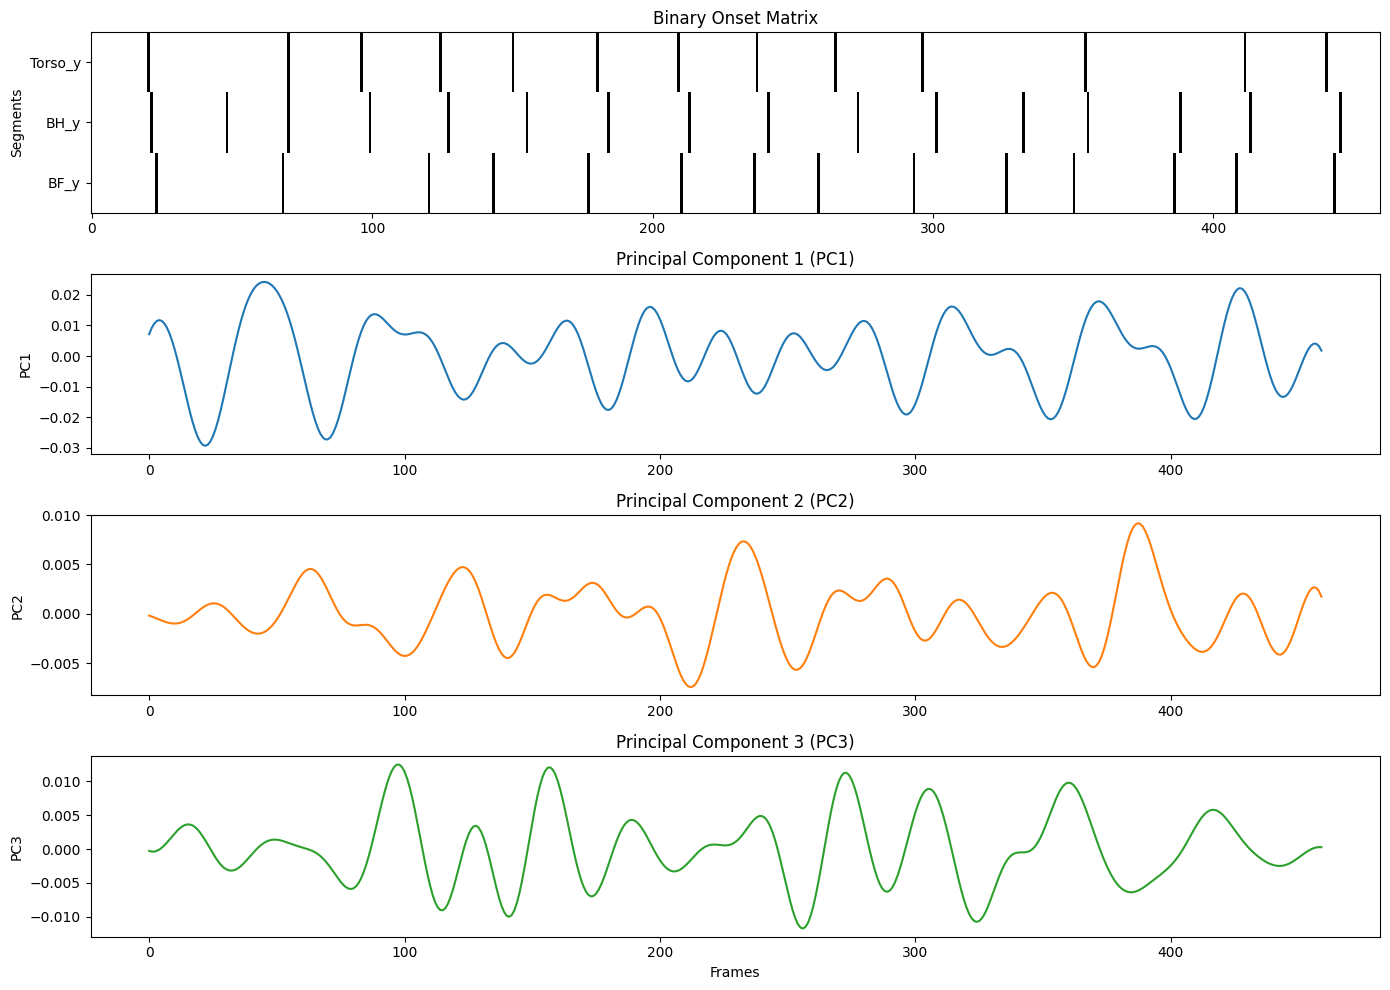

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

metric = "pos"
mode = "zero_uni"

# Path where your onset matrices are stored
onset_matrix_dir = f"/itf-fi-ml/home/sagardu/aist_tempo_est/PCA/onset_matrices/{metric}"

# Get all saved files
files = [f for f in os.listdir(onset_matrix_dir) if f.endswith(".pkl")]

# Pick one randomly
# random_file = files[113]
random_file = random.choice(files)
print("Selected file:", random_file)

# Load the onset matrix
with open(os.path.join(onset_matrix_dir, random_file), "rb") as f:
    data = pickle.load(f)

ref_bpm = data["rbpm"]

onset_mat = data["onset_matrix"]
columns = data["columns"]

print("Onset matrix shape:", onset_mat.shape)

# Optional smoothing (recommended before PCA)
from scipy.ndimage import gaussian_filter1d
onset_smooth = gaussian_filter1d(onset_mat, sigma=10, axis=0)

# --- PCA computation ---
pca = PCA(n_components=3)
O_pca = pca.fit_transform(onset_smooth)

pc1 = detrend_signal_array(O_pca[:, 0].reshape(-1, 1), cutoff= 1, fs=60)
pc2 = detrend_signal_array(O_pca[:, 1].reshape(-1, 1), cutoff= 1, fs=60)
pc3 = detrend_signal_array(O_pca[:, 2].reshape(-1, 1), cutoff= 1, fs=60)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))


# Select last three columns
onset_subset = onset_mat[:, -3:]
columns_subset = columns[-3:]

# --- Visualization ---
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=False)

# (1) Binary onset matrix
axs[0].imshow(onset_subset.T, aspect='auto', cmap='gray_r', interpolation='nearest')
axs[0].set_yticks(np.arange(len(columns_subset)))
axs[0].set_yticklabels(columns_subset)
axs[0].set_title("Binary Onset Matrix")
axs[0].set_ylabel("Segments")

# (2) All PCA components overlay

# (3) Individual PCs
axs[1].plot(pc1, color='C0')
axs[1].set_title("Principal Component 1 (PC1)")
axs[1].set_ylabel("PC1")

axs[2].plot(pc2, color='C1')
axs[2].set_title("Principal Component 2 (PC2)")
axs[2].set_ylabel("PC2")

axs[3].plot(pc3, color='C2')
axs[3].set_title("Principal Component 3 (PC3)")
axs[3].set_xlabel("Frames")
axs[3].set_ylabel("PC3")

plt.tight_layout()
plt.show()


In [12]:
fps = 60
w_sec = 5
h_sec = w_sec/2
window_size = int(fps*w_sec)
hop_size = int(fps*h_sec)
tempi_range = np.arange(60, 140, 1)

for pc in [pc1, pc2, pc3]:


    pc1_onsets = edo.extract_dance_onset(pc.reshape(-1, 1), T_filter=0.25, 
                            smooth_wlen= 10, pk_order = 15, 
                            remove_pk_thres=0.10, height_thres=0.2,
                            mov_avg_winsz = 10, fps = 60,
                            vel_mode= "off", mode = mode)


    novelty_length = len(pc1_onsets["sensor_onsets"])
    sensor_onsets = ctempo.binary_to_peak(pc1_onsets["sensor_onsets"], peak_duration=0.1)
            
    tempogram_ab, tempogram_raw, time_axis_seconds, tempo_axis_bpm = ctempo.compute_tempogram(sensor_onsets, fps, 
                                                                    window_length=window_size, hop_size=hop_size, tempi=tempi_range)


    tempo_data_maxmethod = ctempo.dance_beat_tempo_estimation_maxmethod(tempogram_ab[0], tempogram_raw[0], fps, 
                                                    novelty_length, window_size, hop_size, tempi_range)

    estimated_bpm_per_window = tempo_data_maxmethod["bpm_arr"]
    tempo_median = np.median(estimated_bpm_per_window.flatten())

    print("Reference BPM:", ref_bpm)
    print("Estimated tempo:", tempo_median)

Reference BPM: 125
Estimated tempo: 92.5
Reference BPM: 125
Estimated tempo: 86.0
Reference BPM: 125
Estimated tempo: 104.5


## Difference in beat duration between successive BPM

BPM	Beats/sec	Duration (s/beat)	ΔDuration (s)
60	1.00		1.000			0.000
70	1.17		0.857			-0.143
80	1.33		0.750			-0.107
90	1.50		0.667			-0.083
100	1.67		0.600			-0.067
110	1.83		0.545			-0.055
120	2.00		0.500			-0.045
130	2.17		0.462			-0.038
140	2.33		0.429			-0.033
150	2.50		0.400			-0.029
160	2.67		0.375			-0.025
170	2.83		0.353			-0.022
180	3.00		0.333			-0.020


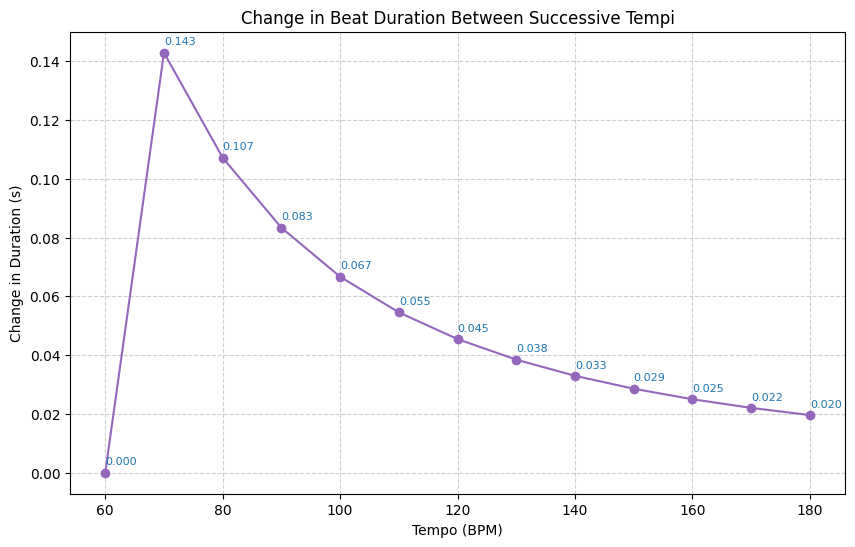

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_beat_duration(bpm_start=60, bpm_end=140, step=10):
    """
    Plots beat duration, beats per second, and duration difference for a BPM range.
    """
    # BPM range
    bpms = np.arange(bpm_start, bpm_end + step, step)
    beats_per_sec = bpms / 60
    beat_duration = 60 / bpms
    duration_diff = np.diff(beat_duration, prepend=beat_duration[0])

    # Print summary table
    print("BPM\tBeats/sec\tDuration (s/beat)\tΔDuration (s)")
    for b, bps, dur, d_diff in zip(bpms, beats_per_sec, beat_duration, duration_diff):
        print(f"{b}\t{bps:.2f}\t\t{dur:.3f}\t\t\t{d_diff:.3f}")

    # --- Plot 1: Beat Duration & Beats per Second ---
    # fig, ax1 = plt.subplots(figsize=(8, 4))
    # ax1.plot(bpms, beat_duration, 'o-', label='Beat Duration (s/beat)', color='tab:blue')
    # ax1.set_xlabel('Tempo (BPM)')
    # ax1.set_ylabel('Duration per beat (s)', color='tab:blue')
    # ax1.tick_params(axis='y', labelcolor='tab:blue')
    # ax1.invert_yaxis()

    # ax2 = ax1.twinx()
    # ax2.plot(bpms, beats_per_sec, 's--', color='tab:red', label='Beats per second')
    # ax2.set_ylabel('Beats per second', color='tab:red')
    # ax2.tick_params(axis='y', labelcolor='tab:red')

    # plt.title('Beat Duration and Beats per Second vs Tempo')
    # fig.tight_layout()
    # plt.show()

    # --- Plot 2: Duration Difference ---
    plt.figure(figsize=(10, 6))
    plt.plot(bpms, np.abs(duration_diff), 'o-', color='tab:purple')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Change in Duration (s)')
    plt.title('Change in Beat Duration Between Successive Tempi')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Label each data point
    for x, y in zip(bpms, np.abs(duration_diff)):
        plt.text(x, y + 0.002, f"{y:.3f}", ha='left', va='bottom', fontsize=8, color='tab:blue')
    
    plt.show()

# Example use
plot_beat_duration(60, 180, 10)


130bpm --- period 0.462 seconds
if actions adds ~40ms, then observed IoI ~ 0.462+0.04 = 0.502

Estimated bpm = 119.5 bpm

# Batch

In [ ]:
def within_tolerance(est_bpm, ref_bpm, tol=0.07):
    if np.isnan(est_bpm) or ref_bpm == 0:
        return False
    return abs(est_bpm - ref_bpm) / ref_bpm <= tol

# -----------------------------
# Main loop
# -----------------------------
fps = 60
w_sec = 5
h_sec = w_sec/2
window_size = int(fps*w_sec)
hop_size = int(fps*h_sec)
tempi_range = np.arange(25, 140, 1)

valid_files = 0

files = [f for f in os.listdir(onset_matrix_dir) if f.endswith(".pkl")]
print(f"Found {len(files)} onset matrix files")

hit = 0
for filename in tqdm(files):
    with open(os.path.join(onset_matrix_dir, filename), "rb") as f:
        data = pickle.load(f)
    
    if "rbpm" not in data or data["rbpm"] is None:
        continue
    
    ref_bpm = data["rbpm"]
    onset_mat = data["onset_matrix"]

    # Smooth and PCA
    onset_smooth = gaussian_filter1d(onset_mat, sigma=5, axis=0)
    pca = PCA(n_components=3)
    O_pca = pca.fit_transform(onset_smooth)

    # Use PC1
    pc1 = detrend_signal_array(O_pca[:, 0].reshape(-1, 1), cutoff=1, fs=fps)
    pc2 = detrend_signal_array(O_pca[:, 1].reshape(-1, 1), cutoff=1, fs=fps)
    pc3 = detrend_signal_array(O_pca[:, 2].reshape(-1, 1), cutoff=1, fs=fps)
    
    


    pc1_onsets = edo.extract_dance_onset(pc1.reshape(-1, 1), T_filter=0.25, 
                            smooth_wlen= 10, pk_order = 15, 
                            remove_pk_thres=0.10, height_thres=0.2,
                            mov_avg_winsz = 10, fps = 60,
                            vel_mode= "off", mode = mode)
    
    pc2_onsets = edo.extract_dance_onset(pc2.reshape(-1, 1), T_filter=0.25, 
                            smooth_wlen= 10, pk_order = 15, 
                            remove_pk_thres=0.10, height_thres=0.2,
                            mov_avg_winsz = 10, fps = 60,
                            vel_mode= "off", mode = mode)
    
    pc3_onsets = edo.extract_dance_onset(pc3.reshape(-1, 1), T_filter=0.25, 
                            smooth_wlen= 10, pk_order = 15, 
                            remove_pk_thres=0.10, height_thres=0.2,
                            mov_avg_winsz = 10, fps = 60,
                            vel_mode= "off", mode = mode)


    novelty_length = len(pc1_onsets["sensor_onsets"])
    
    sensor_onsets1 = ctempo.binary_to_peak(pc1_onsets["sensor_onsets"], peak_duration=0.1)
    sensor_onsets2 = ctempo.binary_to_peak(pc2_onsets["sensor_onsets"], peak_duration=0.1)
    sensor_onsets3 = ctempo.binary_to_peak(pc3_onsets["sensor_onsets"], peak_duration=0.1)
    
    
    
    tempogram_ab1, tempogram_raw1, _, _ = ctempo.compute_tempogram(sensor_onsets1, fps, 
                                            window_length=window_size, hop_size=hop_size, tempi=tempi_range)
    
    tempogram_ab2, tempogram_raw2, _, _ = ctempo.compute_tempogram(sensor_onsets2, fps, 
                                            window_length=window_size, hop_size=hop_size, tempi=tempi_range)
    
    tempogram_ab3, tempogram_raw3, _, _ = ctempo.compute_tempogram(sensor_onsets3, fps, 
                                            window_length=window_size, hop_size=hop_size, tempi=tempi_range)


    tempo_data1 = ctempo.dance_beat_tempo_estimation_maxmethod(tempogram_ab1[0], tempogram_raw1[0], fps, 
                                                    novelty_length, window_size, hop_size, tempi_range)
    
    tempo_data2 = ctempo.dance_beat_tempo_estimation_maxmethod(tempogram_ab2[0], tempogram_raw2[0], fps, 
                                                    novelty_length, window_size, hop_size, tempi_range)
    
    tempo_data3 = ctempo.dance_beat_tempo_estimation_maxmethod(tempogram_ab3[0], tempogram_raw3[0], fps, 
                                                    novelty_length, window_size, hop_size, tempi_range)

    estimated_bpm_per_window1 = tempo_data1["bpm_arr"]
    tempo_median1 = np.median(estimated_bpm_per_window1.flatten())
    
    estimated_bpm_per_window2 = tempo_data2["bpm_arr"]
    tempo_median2 = np.median(estimated_bpm_per_window2.flatten())
    
    estimated_bpm_per_window3 = tempo_data3["bpm_arr"]
    tempo_median3 = np.median(estimated_bpm_per_window3.flatten())


    tempo_candidates = [[tempo_median1, tempo_median2, tempo_median3]]
    dts_acc,_,_ = compute_dts(np.array([ref_bpm]), tempo_candidates, tau=0.10, mode = "many")
    
    if dts_acc > 0:
        hit += 1
    

Found 1341 onset matrix files


100%|██████████| 1341/1341 [01:03<00:00, 21.03it/s]


In [48]:
total = len(files)
accuracy = hit / total
print("accuracy:", accuracy)

accuracy: 0.7897091722595079


In [33]:
type(ref_bpm)

int